# <span style="color:teal"> Deep Reinforcement Learning for Atari Enduro-v0 </span>

### Import Required Packages

In [2]:
from time import sleep
from __future__ import division

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam
from keras.activations import relu, linear
from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

***
### RoadRunner Environment

C:\Users\lauri\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment Enduro-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Enduro-v5`.
  logger.warn(


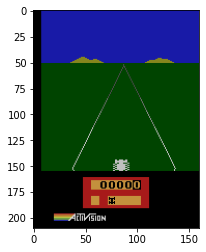

In [3]:
env = gym.make('Enduro-v0')

plt.imshow(env.render(mode='rgb_array'))

#### 1. *Number of possible action*

In [4]:
nb_actions = env.action_space.n
print('Total number of Possible actions in Enduro is :', nb_actions)

Total number of Possible actions in Enduro is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [5]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [6]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## DeepMind Architecture

In [7]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 activation_1 (Activation)   (None, 9, 9, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0

***
### Configuring the Agent

#### 1. *Allocating memory for experience replay*

In [8]:
memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.* Policy: Epsilon Greedy Exploration*
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [9]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

#### 3. *Compiling DQN Agent*

In [11]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [13]:
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

***
## <span style="color:teal"> Training the model </span>

### <span style="color:red">**-  -  Caution   -  -**</span>

In [15]:
history = dqn.fit(env, nb_steps=20000)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 1125s 113ms/step - reward: 0.0000e+00
2 episodes - episode_reward: 0.000 [0.000, 0.000] - lives: 0.000 - episode_frame_number: 6101.362 - frame_number: 15798.530

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 167s 17ms/step - reward: 0.0000e+00
done, took 1292.732 seconds


### <span style="color:blue">**-  -  -  Safe  -  -  -**</span>

In [16]:
dqn.load_weights('dqn_atari_Enduro.h5f')

***
## <span style="color:teal"> Testing the model </span>

In [1]:
env.reset()

dqn.test(env, nb_episodes=1, visualize=True)

plt.imshow(env.render())

env.close()

NameError: name 'env' is not defined

**Trained on: Intel® Xeon® Processor E5, 2.40 GHz, Nvidia Quadro K4200**
***
<span style="color:teal"> [Bhartendu Thakur](https://github.com/matrixBT), Machine Learning & Computing</span>